# Scripts for Toymodel 2. 

##### Please cite [.]: Van A. Ngo, Yen Ting Li, Danny Perez. "Improving Estimatioon of Koopman Operators with Kolmogorov-Smirnov Indicator functions." Copyright: LANL.

In [1]:
import numpy as np
import pandas as pd
import pyemma
import pyemma.coordinates as coor
from matplotlib import rcParams
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
#Major scripts here
# build 2D KS matrix
def KS_measure(x,block=100):
    from scipy.stats import ks_2samp
    d1=np.reshape(x, x.size)
    #block=100000
    print('using block =',block)
    l=len(d1)
    nb=int(l/block)
    KS=np.zeros((nb,nb))
    for i in range(nb):
        ki1=i*block
        ki2=(i+1)*block
        dai=d1[ki1:ki2]
        for j in range(i,nb):
            kj1=j*block
            kj2=(j+1)*block
            daj=d1[kj1:kj2]
            D,p=ks_2samp(dai,daj)
            KS[i,j]=D
            KS[j,i]=D
    return KS
# For print out
def KS_measure_test(x,block=100):
    from scipy.stats import ks_2samp
    d1=np.reshape(x, x.size)
    #block=100000
    print('using block =',block)
    l=len(d1)
    nb=int(l/block)
    KS=np.zeros((nb,nb))
    for i in range(1):
        ki1=i*block
        ki2=(i+1)*block
        dai=d1[ki1:ki2]
        for j in range(i,nb):
            kj1=j*block
            kj2=(j+1)*block
            daj=d1[kj1:kj2]
            D,p=ks_2samp(dai,daj)
            print('D Statistic=',D,'pvalue=',p,'is it <1% to reject null hypothesis (=same distribution)')

#Clustering using Distance Threshold in AgglomerativeClustering
class clustering:
    def __init__(self,KS,k=6,block=100):
        from scipy.cluster.hierarchy import dendrogram, linkage
        from scipy.cluster.hierarchy import fcluster
        import sklearn.cluster
        def kdtd(n):
            return 1.6*np.sqrt(2*n/n**2)*k
        print("Danny's Threshold: ",kdtd(block))
        cls=sklearn.cluster.AgglomerativeClustering(n_clusters=None,  affinity='precomputed', memory=None, connectivity=None, compute_full_tree='auto', linkage='average', distance_threshold=kdtd(block))
        #cls.fit(KS)
        self.clustertime=cls.fit(KS).labels_
        
        tg2=[]
        av=np.average(self.clustertime)
        nstate=np.unique(self.clustertime)
        for st  in nstate:
            tg=[]
            print('indicator function ', st)
            for cl in self.clustertime:
                if cl == st:
                    tg=np.concatenate((tg,np.full(block,1)))
                else:
                    tg=np.concatenate((tg,np.full(block,0)))
            tg2.append(tg)    
        self.cluster_KS_surrogate=tg2
        self.Single_cluster_KS_surrogate=[]
        for cl in self.clustertime:
            self.Single_cluster_KS_surrogate=np.concatenate((self.Single_cluster_KS_surrogate,np.full(block,cl-av)))

# Clustering using number of clusters in AgglomerativeClustering
class clustering2:
    def __init__(self,KS,k=2,block=100):
        from scipy.cluster.hierarchy import dendrogram, linkage
        from scipy.cluster.hierarchy import fcluster
        import sklearn.cluster
        #def kdtd(n):
        #    return 1.6*np.sqrt(2*n/n**2)*k
        print("Using number of ",k,'clusters')
        cls=sklearn.cluster.AgglomerativeClustering(n_clusters=k,  affinity='precomputed', memory=None, connectivity=None, compute_full_tree='auto', linkage='average')
        #cls.fit(KS)
        self.clustertime=cls.fit(KS).labels_
        
        tg2=[]
        av=np.average(self.clustertime)
        nstate=np.unique(self.clustertime)
        self.Single_cluster_KS_surrogate=[]
        for st  in nstate:
            tg=[]
            print('indicator function ', st)
            for cl in self.clustertime:
                
                if cl == st:
                    tg=np.concatenate((tg,np.full(block,1)))
                else:
                    tg=np.concatenate((tg,np.full(block,0)))
            tg2.append(tg)    
        self.cluster_KS_surrogate=tg2
        for cl in self.clustertime:
            self.Single_cluster_KS_surrogate=np.concatenate((self.Single_cluster_KS_surrogate,np.full(block,cl-av)))

In [3]:
# computing timescale using k-means clustering and MSM
def get_timescale(x,kmeans=2,lag=20,max_iter=100,dovamp=False,doplot=True,doclustering=True):
    import pyemma
    import pyemma.coordinates as coor
    import numpy as np
    output=x
    if dovamp:
        print('perform VAMP transformation')
        output=coor.vamp(x,lag=lag).get_output();# this step is not necessary for toy model 1
    
    if doclustering:
        print('do k-means clustering with',kmeans,'clusters','lagtime=',lag)
        vamp_clustering=coor.cluster_kmeans(data=output,k=kmeans,max_iter=max_iter)
        dtrajs=vamp_clustering.dtrajs
    else:
        dtrajs=x
    msm=pyemma.msm.estimate_markov_model(dtrajs,lag=lag)
    timescale=msm.timescales()[0]
    #plot x vs dtrajs
    if doplot:
        time=np.arange(len(dtrajs[0]))
        fig,ax=plt.subplots(1,1)
        ax.plot(time,x)
        ax.plot(time,dtrajs[0],label='k-means')
        ax.set_ylim(min(x)-0.5,max(x)+0.5)
    #ax.set_yticks(np.arange(0,1.5,1))
        ax.set_ylabel('Discretized Trajectory',weight='bold')
        ax.set_xlabel('Time (step)',weight='bold')
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.savefig('kmeans_clustering_traj-model1.png',dpi=100,bbox_inches='tight')
        plt.show()

    return timescale

In [4]:
# compute indicator functions with KS measure and AgglomerativeClustering
def get_indicator(x,b=500,k=2,clustering_type='nclusters'):
    KS=KS_measure(x,block=b)
    if clustering_type == 'nclusters':
        KS_clustering=clustering2(KS,k=k,block=b); # if clustering with number of cluster
    if clustering_type == 'Distance':
        KS_clustering=clustering(KS,k=k,block=b); # k here is the constant for computing distance threshold
    #it takes some minutes to compute KS proximity matrix
    #put x and indicator functions together
    l=min(len(x),len(KS_clustering.cluster_KS_surrogate[0])); # just in case len(x)%b !=0
    data1=[x[:l]]
    for tg in KS_clustering.cluster_KS_surrogate:
        data1.append(tg)
    data1=np.asarray(data1).T
    print(np.shape(data1))
    #print(data1)
    return data1

# Parameters for toy model 2

In [5]:

length=500000
b=500
sigma=np.asarray([0.5, 0.5]); ### different from model 1
mu = np.asarray([0.0, 1])
trans=np.asarray([0.0001, 0.0001])
lag=20
k=6; # using for computing distance threshold

In [6]:
# load panda pickle which contains 100 in dependent trajectories with a length = 500000/traj.
df=pd.read_pickle('../data/100_samples_toy_model2.pkl')
print(df)

                                           timeseries  \
0   [0.29548390141667835, 0.3614549025150612, 0.26...   
1   [0.051134014755299835, -0.13511577244054673, -...   
2   [-0.10382704637840376, 0.062086797195952864, 0...   
3   [-0.7393356197720244, 0.19786108059554397, 0.0...   
4   [-0.2034745950195965, -0.13303581196086942, 0....   
..                                                ...   
95  [0.8305838710266434, -0.10501471558370634, -0....   
96  [-0.07477951075078747, -0.11243111508425617, -...   
97  [-0.08613927545051822, 0.5447487622969105, 0.2...   
98  [-0.3276534362052586, -0.07371280651713802, 0....   
99  [-0.20142041090584817, 0.29437141015480733, -0...   

                                  indicator functions  \
0   [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...   
1   [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...   
2   [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...   
3   [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...   
4   [[0.0, 1.0], [0.0, 1.0], [

In [7]:
#Pick a trajectory and plot it
fr=9
x=df['timeseries'][fr]
ind=df['indicator functions'][fr][:,1]; # there are two complementary indicator functions for each time-series x.

kmeans iterations:   0%|                                                              | 0/200 [00:00<?, ?it/s]

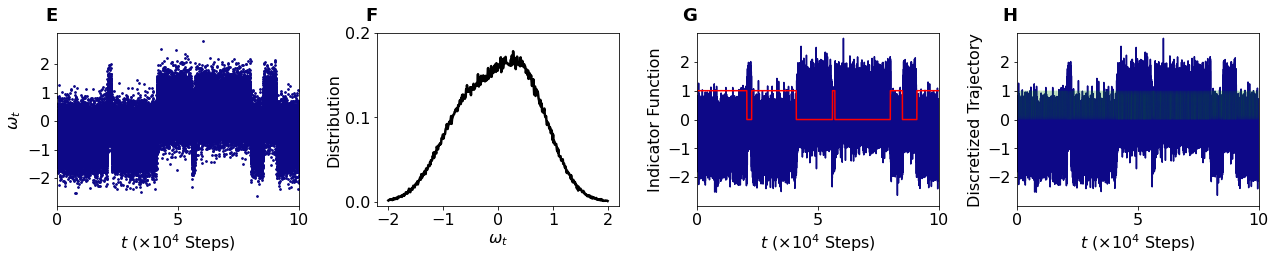

In [18]:
# Plot Figure 2(E-H)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':16, 'font.family':'sans'})
fig = plt.figure(figsize=(18,4))
ax = [plt.subplot(1,4,i+1) for i in range(4)]
colors = cm.plasma(np.linspace(0,1,12))
ms = 3
letter=['E', 'F', 'G', 'H']
xlabel=[r'$t$ $(\times 10^4$ $\mathrm{Steps})$',r'$\omega_t$',
        r'$t$ $(\times 10^4$ $\mathrm{Steps})$',
        r'$t$ $(\times 10^4$ $\mathrm{Steps})$']
ylabel=[r'$\omega_t$','Distribution','Indicator Function','Discretized Trajectory']
#get zero mean
x0=x-np.average(x)
hisx,ix=np.histogram(x0,bins=500,range=[-2,2])
hisx=hisx/np.sum(hisx)*40
#compute discretize trajectory from kmeans, also indicator function
discretize_clustering=coor.cluster_kmeans(data=x0,k=2,max_iter=200)
dtrajs=discretize_clustering.dtrajs
for i in range(0,4):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
    ax[i].text(0, 1.15, letter[i], transform=ax[i].transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')
t=np.arange(0,len(x),1)
ax[0].scatter(t/10000,x0, ms,  color = colors[0]); # raw data
ax[1].plot(ix[:500], hisx, ms,  color = 'black',lw=2.5); #histogram

ax[2].plot(t/10000,x0,ms,  color = colors[0]); #raw data
ax[2].plot(t/10000,ind,ms,  color = 'red'); #indicator function

ax[3].plot(t/10000,x0,ms,  color = colors[0]); #raw data
ax[3].plot(t/10000,np.full(len(dtrajs[0]),1)-dtrajs[0],lw=0.02,  color = 'green'); #discretized

ax[0].set_yticks(np.arange(-2,3))
ax[1].set_ylim(-0.005,.1)
ax[1].set_yticks([0,0.1,0.2])
ax[0].set_xticks([0,5,10])
for i in [0,2,3]:
    ax[i].set_xlim(0,10)
for i in [2,3]:
    ax[i].set_ylim(-3.,3.)
    ax[i].set_yticks(np.arange(-2,3))
    ax[i].set_xticks([0,5,10])

plt.tight_layout()
fig.savefig('HMM_toymodel2.png',dpi=300,bbox_inches='tight')

count= 56000
KstestResult(statistic=0.3235390781563126, pvalue=8.604710045546964e-24)


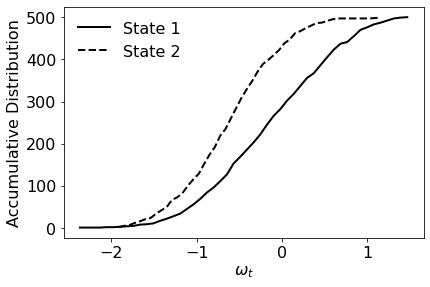

In [24]:

#Finding time t at which there is a jump in the indicator function
i=50000
e0=ind[i]
count=i
for e in ind[i:]:
    if e!=e0:
        print('count=',count)
        break
    count+=1
block=500
xs0=x0[count-block:count]
xs1=x0[count+1:count+block]
from scipy import stats
nbins=50
res0=stats.cumfreq(xs0,numbins=nbins)
ix0 = res0.lowerlimit + np.linspace(0, res0.binsize*res0.cumcount.size,
                                 res0.cumcount.size)
res1=stats.cumfreq(xs1,numbins=nbins)
ix1 = res1.lowerlimit + np.linspace(0, res1.binsize*res1.cumcount.size,
                                 res1.cumcount.size)

plt.plot(ix0,res0.cumcount,color='black',label='State 1',lw=2)
plt.plot(ix1,res1.cumcount,ls='--',color='black',label='State 2',lw=2)
plt.tight_layout()
plt.legend(frameon=False)
from scipy.stats import ks_2samp
print(ks_2samp(xs0,xs1))
plt.xlabel(r'$\omega_t$')
plt.ylabel('Accumulative Distribution')
plt.savefig('KScumulative.png',dpi=300,bbox_inches='tight')



In [14]:
#compute timescale using x-$\muy$
vamp_x=coor.vamp(x,lag=lag)
t_x=-lag/np.log(vamp_x.singular_values[0])
print('computed timescale is',t_x,'----pre-computed is',df['Timescale using x-$\muy$'][fr])

computed timescale is 28.07161331090908 ----pre-computed is 28.07161331090908


perform VAMP transformation
do k-means clustering with 2 clusters lagtime= 20


kmeans iterations:   0%|                                                              | 0/100 [00:00<?, ?it/s]

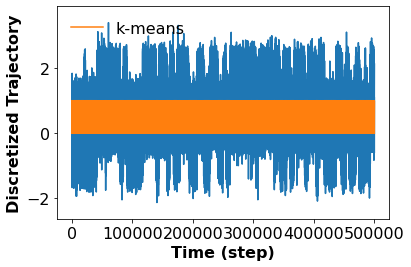

computed timescale using k-means clustering and MSM is 25.122064295577637


In [15]:
# compute timescale using k-means clustering and MSM
t_MSM= get_timescale(x,dovamp=True)
print('computed timescale using k-means clustering and MSM is',t_MSM)
#t_MSM should be close to df['Timescale using Indicator Function'][fr] for Toy model 1

In [16]:
data1=get_indicator(x,b=b,k=6)

using block = 500
Danny's Threshold:  0.6071573107523288
indicator function  0
indicator function  1
(500000, 3)


0.596 0.404


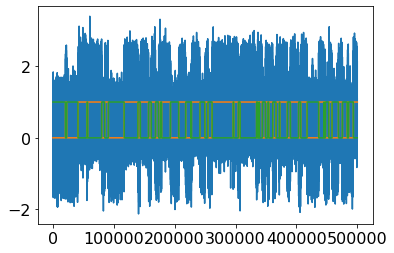

In [17]:
plt.plot(data1[:,0])
plt.plot(data1[:,1])
plt.plot(data1[:,2]);# the second indicator function should be complementary to the first
print(np.average(data1[:,1]),np.average(data1[:,2]))

In [15]:
#compute timescale with {indicator functions} and with both {x and indicator functions} as basis sets
vamp_IF=coor.vamp(data1[:,1:],lag=lag,dim=1);# dim = 1 is for comparing VAMP-score with the same dimension
vamp_xIF=coor.vamp(data1,lag=lag,dim=1)
print('VAMPScore for {x} as basis set is',vamp_x.score(),'with timescale is',-lag/np.log(vamp_x.singular_values[0]))
print('VAMPScore for {Indicator Function} as basis set is',vamp_IF.score(),
      'with timescale is',-lag/np.log(vamp_IF.singular_values[0]))
print('VAMPScore for {x and Indicator Function} as basis set is',vamp_xIF.score(),
      'with timescale is',-lag/np.log(vamp_xIF.singular_values[0]))
print('the pre-computed timescale is',df['Timescale using Indicator Function'][fr])

VAMPScore for {x} as basis set is 1.240526018741594 with timescale is 28.07161331090908
VAMPScore for {Indicator Function} as basis set is 1.9902222875794897 with timescale is 4070.903683108181
VAMPScore for {x and Indicator Function} as basis set is 1.990258705486751 with timescale is 4086.1978042033516
the pre-computed timescale is 4086.1978042033516


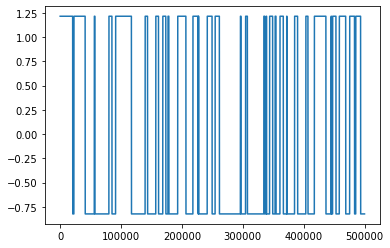

In [16]:
plt.plot(np.stack(vamp_IF.get_output()[0]))

In [7]:
# Compute Vamp scores as function of lag time
def timescale_vs_lag(x0,ind,lag_range):
    org=[]
    IF=[]
    t_org=[]
    t_IF=[]
    for lag in lag_range:
        vamp_x=coor.vamp(x0,dim=1,lag=lag)
        vamp_IF=coor.vamp(ind,dim=1,lag=lag)
        org.append(vamp_x.score())
        IF.append(vamp_IF.score())
        t_org.append(-lag/np.log(vamp_x.singular_values[0]))
        t_IF.append(-lag/np.log(vamp_IF.singular_values[0]))
    return org,IF,t_org,t_IF
lag_range=range(20,10000,100)
vs_org=[]
vs_IF=[]
ts_org=[]
ts_IF=[]
for x,aind in zip(df['timeseries'],df['indicator functions']):
    x0=x-np.average(x)
    ind=aind[:,1]
    org,IF,t_org,t_IF=timescale_vs_lag(x0,ind,lag_range)
    vs_org.append(org)
    vs_IF.append(IF)
    ts_org.append(t_org)
    ts_IF.append(t_IF)

In [8]:
#computing timescale using kmeans+MSM for all trajectories

all_dtrajs=[]
for x in df['timeseries']:
    kmeans_clustering=coor.cluster_kmeans(data=x,k=2,max_iter=100)
    dtrajs=kmeans_clustering.dtrajs
    all_dtrajs.append(dtrajs)

ts_MSM=[]
for dtrajs in all_dtrajs:
    lt_x_MSM=[]
    for lag in lag_range:
        msm=pyemma.msm.estimate_markov_model(dtrajs,lag=lag)
        lt_x_MSM.append(msm.timescales()[0])
    ts_MSM.append(lt_x_MSM)

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

In [11]:
#compute averages and errors of the mean
n=len(lag_range)
nsample=len(df['timeseries'])
print(n,nsample)
ave_vs_org=[]
ave_vs_IF=[]
ave_ts_org=[]
ave_ts_IF=[]
ave_ts_MSM=[]

e_vs_org=[]
e_vs_IF=[]
e_ts_org=[]
e_ts_IF=[]
e_ts_MSM=[]
for i in range(n):
    #vampscore
    ave_vs_org.append(np.average(np.vstack(vs_org)[:,i]))
    ave_vs_IF.append(np.average(np.vstack(vs_IF)[:,i]))
    #timescale
    ave_ts_org.append(np.average(np.vstack(ts_org)[:,i]))
    ave_ts_IF.append(np.average(np.vstack(ts_IF)[:,i]))
    ave_ts_MSM.append(np.average(np.vstack(ts_MSM)[:,i]))
    #error for vampscore
    e_vs_org.append(np.std(np.vstack(vs_org)[:,i])/np.sqrt(nsample))
    e_vs_IF.append(np.std(np.vstack(vs_IF)[:,i])/np.sqrt(nsample))
    #error for timescale
    e_ts_org.append(np.std(np.vstack(ts_org)[:,i])/np.sqrt(nsample))
    e_ts_IF.append(np.std(np.vstack(ts_IF)[:,i])/np.sqrt(nsample))
    e_ts_MSM.append(np.std(np.vstack(ts_MSM)[:,i])/np.sqrt(nsample))
    print("%f %.2f +/- %.2f, %.2f +/- %.2f, %.2f +/- %.2f, %.2f +/- %.2f," %
          (lag_range[i],ave_vs_org[-1],e_vs_org[-1],
           ave_vs_IF[-1], e_vs_IF[-1],
           ave_ts_org[-1],e_ts_org[-1],
           ave_ts_IF[-1], e_ts_IF[-1]),
           ave_ts_MSM[-1], e_ts_MSM[-1])
            
                   

100 100
20.000000 1.24 +/- 0.00, 1.99 +/- 0.00, 28.33 +/- 0.06, 5382.28 +/- 75.10, 25.493728891303498 0.08797546869177902
120.000000 1.23 +/- 0.00, 1.96 +/- 0.00, 165.17 +/- 0.34, 5330.98 +/- 75.09, 149.0703924658476 0.514155217720601
220.000000 1.22 +/- 0.00, 1.92 +/- 0.00, 294.76 +/- 0.67, 5279.35 +/- 75.08, 266.76226131683524 0.9420972013701728
320.000000 1.22 +/- 0.00, 1.88 +/- 0.00, 417.32 +/- 0.97, 5227.39 +/- 75.07, 378.73714923065944 1.3561398491659813
420.000000 1.21 +/- 0.00, 1.85 +/- 0.00, 533.81 +/- 1.36, 5175.07 +/- 75.07, 485.5304083857308 1.776728252542225
520.000000 1.20 +/- 0.00, 1.81 +/- 0.00, 644.49 +/- 1.76, 5138.78 +/- 74.98, 587.6188302746862 2.2221846641063503
620.000000 1.19 +/- 0.00, 1.78 +/- 0.00, 749.91 +/- 2.23, 5153.31 +/- 74.75, 684.7812543131394 2.6673666751421132
720.000000 1.18 +/- 0.00, 1.75 +/- 0.00, 850.41 +/- 2.69, 5150.32 +/- 74.75, 778.4142787380681 3.161564507980014
820.000000 1.18 +/- 0.00, 1.72 +/- 0.00, 945.64 +/- 3.20, 5135.62 +/- 74.86, 867.

8120.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3373.39 +/- 68.54, 4874.61 +/- 138.43, 3263.0947300898574 64.66403123386813
8220.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3383.65 +/- 69.11, 4876.07 +/- 138.97, 3273.0778307208266 65.35093502503639
8320.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3392.06 +/- 70.28, 4874.95 +/- 140.00, 3286.255671303169 65.92110969294967
8420.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3399.04 +/- 72.06, 4867.70 +/- 142.46, 3289.1302536365815 69.05028211393048
8520.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3415.70 +/- 71.51, 4873.84 +/- 141.54, 3308.181529183226 67.44737477909057
8620.000000 1.01 +/- 0.00, 1.04 +/- 0.00, 3429.88 +/- 71.49, 4877.51 +/- 141.76, 3322.460783942524 67.41696456722084
8720.000000 1.01 +/- 0.00, 1.03 +/- 0.00, 3442.26 +/- 72.38, 4878.08 +/- 142.62, 3335.612534185843 68.36314890703677
8820.000000 1.01 +/- 0.00, 1.03 +/- 0.00, 3455.18 +/- 72.77, 4881.59 +/- 142.65, 3349.3243822659833 68.91521412034503
8920.000000 1.01 +/- 0.00, 1.03 +/- 0.00, 3462.88 +/- 74.49,

In [19]:
lag_range,ave_vs_org,e_vs_org,ave_vs_IF, e_vs_IF,ave_ts_org,e_ts_org,ave_ts_IF, e_ts_IF,ave_ts_MSM, e_ts_MSM=np.loadtxt('figure3b_data.txt',unpack=True)

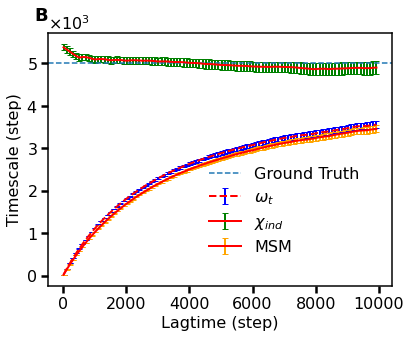

In [27]:
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=16,weight='normal')

llag=np.arange(20,10000,100)
fig,ax2=plt.subplots(1,1,figsize=(6,5))
#ax=ax2.twinx()
ax2.set_xlabel('Lagtime (step)',weight='normal')
#ax.set_ylabel('VAMP Score',weight='normal')
#ax.errorbar(llag,ave_vs_org,yerr=e_vs_org,ls='--',color='black',linewidth=2,label=r'$\omega_t$')
#ax.errorbar(llag,ave_vs_IF,yerr=e_vs_IF,color='black',linewidth=2,label=r'$\chi_{ind}$')

ax2.errorbar(llag,ave_ts_org,yerr=e_ts_org,ecolor='blue',capsize=3,ls='--',color='red',linewidth=2,label=r'$\omega_t$')
ax2.errorbar(llag,ave_ts_IF,yerr=e_ts_IF,ecolor='green',capsize=3,color='red',linewidth=2,label=r'$\chi_{ind}$')
ax2.errorbar(llag,ave_ts_MSM,yerr=e_ts_MSM,ecolor='orange',capsize=3,color='red',linewidth=2,label=r'MSM')
ax2.set_ylabel("Timescale (step)",color="black")
ax2.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
ax2.set_yticks(np.arange(0,6000,1000))
ax2.axhline(y=5000,ls='--',label='Ground Truth')
#ax2.set_ylim(0,5000)
#ax.set_ylim(1.,2.5)
#ax.set_yticks([1,1.5,2,2.5])
ax2.text(0, 1.1, 'B', transform=ax2.transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')
#ax.set_ylim(1,2)
#ax.legend(frameon=False,loc=[0.7,0.185])
ax2.legend(frameon=False,loc=[0.45,0.1])
plt.tight_layout()
plt.savefig('ToyModel2_VAMP_score.png',dpi=300,bbox_inches='tight')

# Examine quality of indicator functions as functions of $d_{\mathrm{KS}}$ (distance threshold) via b (block size) and number of clusters

In [21]:
#1. test for b (delta_t in Figure 5) (not using $d_{KS}, but fix nclusters=2)
def timescale_vs_b(x,k=2,lag=1000,brange=range(200,1500,50)):
    timescale=[]
    for tblock in brange:
        #xind=get_indicator(x,b=tblock,k=k,clustering_type='Distance'); # can test this as well
        xind=get_indicator(x,b=tblock,k=k,clustering_type='nclusters')
        vamp_xind=coor.vamp(xind,dim=1,lag=lag)
        timescale.append(-lag/np.log(vamp_xind.singular_values[0]))
    return timescale
print('Computing timecale for all samples for block')
ts_vs_b=[]
countsp=0
nsample=10; # get similar order of errors (~100) if using 100 samples; saving computational time.
brange=range(200,1500,50)
for x in df['timeseries']:
    ts_vs_b.append(timescale_vs_b(x))
    countsp+=1
    print('sample',countsp)
    if countsp == nsample:
        break

Computing timecale for all samples for block
using block = 200
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 250
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 300
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 350
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 

indicator function  1
(500000, 3)
using block = 300
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 350
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
in

indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 800
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 850
Using number of  2 clusters
in

indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 800
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 850
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 900
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 950
Using number of  2 clusters
in

In [22]:
#2. test for number of clusters
def timescale_vs_nclusters(x,b=500,lag=1000,nrange=[1,2,4,6,8]):
    timescale=[]
    for k in nrange:
        vamp_x=coor.vamp(x,lag=lag)
        xind=get_indicator(x,b=b,k=k,clustering_type='nclusters')
        vamp_xIF=coor.vamp(xind,dim=1,lag=lag)
        t_xIF=-lag/np.log(vamp_xIF.singular_values[0])
        timescale.append(t_xIF)
    return timescale
##### do for all samples
print('Computing timecale for all samples for nclusters')
ts_vs_nclusters=[]
countsp=0
nsample=10; # get similar order of errors (~100) if using 100 samples; saving computational time.
for x in df['timeseries']:
    ts_vs_nclusters.append(timescale_vs_nclusters(x))
    countsp+=1
    print('sample',countsp)
    if countsp == nsample:
        break
#########



Computing timecale for all samples for nclusters
using block = 500
Using number of  1 clusters
indicator function  0
(500000, 2)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  4 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
(500000, 5)
using block = 500
Using number of  6 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
indicator function  4
indicator function  5
(500000, 7)
using block = 500
Using number of  8 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
indicator function  4
indicator function  5
indicator function  6
indicator function  7
(500000, 9)
sample 1
using block = 500
Using number of  1 clusters
indicator function  0
(500000, 2)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using bl

In [23]:
print(np.shape(np.vstack(ts_vs_b)))
print(np.shape(np.vstack(ts_vs_nclusters)))
ave_ts_vs_b=[]
ave_ts_vs_n=[]

e_ts_vs_b=[]
e_ts_vs_n=[]
#brange=range(250,3000,250)
for i in range(len(brange)):
    
    #timescale
    ave_ts_vs_b.append(np.average(np.vstack(ts_vs_b)[:,i]))
    #error for timescale
    e_ts_vs_b.append(np.std(np.vstack(ts_vs_b)[:,i])/np.sqrt(nsample))
    print("%f %.2f +/- %.2f" %
          (i,ave_ts_vs_b[-1],e_ts_vs_b[-1]))

####       
nrange = [1,2,4,6,8]    
for i in range(len(nrange)):
    
    #timescale
    ave_ts_vs_n.append(np.average(np.vstack(ts_vs_nclusters)[:,i]))
    #error for timescale
    e_ts_vs_n.append(np.std(np.vstack(ts_vs_nclusters)[:,i])/np.sqrt(nsample))
    
    print("%f %.2f +/- %.2f " %
          (i,ave_ts_vs_n[-1], e_ts_vs_n[-1]))

(10, 26)
(10, 5)
0.000000 5010.93 +/- 244.50
1.000000 5030.83 +/- 246.21
2.000000 5101.77 +/- 257.76
3.000000 5080.65 +/- 238.35
4.000000 5106.85 +/- 251.31
5.000000 5144.05 +/- 281.39
6.000000 5028.32 +/- 240.33
7.000000 5057.25 +/- 256.26
8.000000 5132.22 +/- 280.57
9.000000 5147.95 +/- 219.61
10.000000 5246.27 +/- 250.50
11.000000 5240.84 +/- 287.72
12.000000 5232.09 +/- 266.17
13.000000 5200.72 +/- 293.71
14.000000 5201.49 +/- 255.97
15.000000 5223.33 +/- 273.03
16.000000 5299.30 +/- 294.86
17.000000 5420.62 +/- 336.65
18.000000 5376.84 +/- 258.98
19.000000 5379.34 +/- 250.47
20.000000 5465.29 +/- 260.24
21.000000 5424.81 +/- 310.87
22.000000 5476.55 +/- 336.27
23.000000 5504.83 +/- 321.34
24.000000 5530.54 +/- 307.13
25.000000 5559.02 +/- 340.10
0.000000 1107.51 +/- 14.51 
1.000000 5028.32 +/- 240.33 
2.000000 6061.01 +/- 283.04 
3.000000 6401.24 +/- 296.83 
4.000000 6565.41 +/- 305.57 


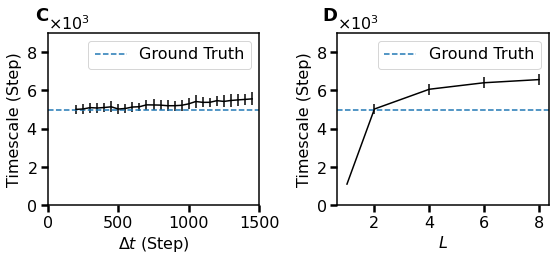

In [24]:
# Plot Figure 2(D-F)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':16, 'font.family':'sans'})
fig = plt.figure(figsize=(8,4))
ax = [plt.subplot(1,2,i+1) for i in range(2)]
colors = cm.plasma(np.linspace(0,1,12))
ms = 3
letter=['C', 'D']
xlabel=[r'$\Delta t$ (Step)',r'$L$']
ylabel=[r'Timescale (Step)',r'Timescale (Step)']
#print(e_ts_vs_b)
for i in range(2):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
    ax[i].text(0, 1.15, letter[i], transform=ax[i].transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')

for i in [0,1]:
    ax[i].set_ylim(0,9000)
    ax[i].axhline(y=5000,ls='--',label='Ground Truth')
    ax[i].set_yticks([0,2000,4000,6000,8000])
    ax[i].ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
    ax[i].legend()
ax[0].set_xticks(np.arange(0,1550,500))
ax[0].set_xlim(0,1500)
ax[0].errorbar(brange,ave_ts_vs_b,yerr=e_ts_vs_b,   color = 'black');
ax[1].errorbar(nrange,ave_ts_vs_n,yerr=e_ts_vs_n,  color = 'black'); 



plt.tight_layout()
fig.savefig('dKS_toymodel2.png',dpi=300,bbox_inches='tight')

# Test timescale as function of $\mu$ 


In [23]:
#load data from pickle
muydata=pd.read_pickle('../data/Muy2_samples_toy_model2.pkl')
print(muydata)

    sigma1=sigma2  muy2                                         timeseries  \
0             0.5   0.2  [-0.24581993489386694, -0.524272804489954, -0....   
1             0.5   0.4  [0.2766510105086693, 0.47927702522644744, -0.2...   
2             0.5   0.6  [-0.019356237534059757, 0.11878022398970049, 1...   
3             0.5   0.8  [0.16062284119724723, -0.7761228949544938, 0.2...   
4             0.5   1.0  [0.22711920588683152, 0.0238174266893877, -0.1...   
5             0.5   1.2  [0.49824065232858517, 0.22689602631032457, 0.4...   
6             0.5   1.4  [0.4818538618317174, -0.5376444021717667, 0.35...   
7             0.5   1.6  [-0.497988142929987, 0.7148001380649844, 0.199...   
8             0.5   1.8  [0.754887145328512, 1.1301701264928818, -0.240...   
9             0.5   2.0  [-0.543486307755526, 1.0501725211962198, -0.23...   
10            0.5   2.2  [0.49091728042213123, 0.796550033260116, -0.88...   
11            0.5   2.4  [0.02866304432185789, 0.315410569516596

In [52]:
def compare_VAMP_vs_theoretical(sigma0=muydata['sigma1=sigma2'][0],
                                lag=20,timeseries=muydata['timeseries'],
                                indicators=muydata['Ground True Hidden functions'],
                                allmuy=muydata['muy2'],p1=trans[0],p2=trans[1],maxi=500000,b=500,ntraj=-1):
    pi1=p1/(p1+p2)
    pi2=p2/(p1+p2)
    # note sigma[0]==sigma[1] for simply
    t_xVAMP=[]
    t_iVAMP=[]
    t_iKSVAMP=[]
    t_iMSM=[]
    tmuy_theo=[]
    counttraj=0
    for muy2,x,indi in zip(allmuy,timeseries,indicators):

        gamma=1/(4*(sigma0/muy2)**2+1)
        vamp_x=coor.vamp(x[:maxi],dim=1,lag=lag)
        t_x=-lag/np.log(vamp_x.singular_values[0])
        t_xVAMP.append(t_x)
        
        #using ground true indicator functions
        vamp_i=coor.vamp(indi[:maxi],dim=1,lag=lag)
        t_i=-lag/np.log(vamp_i.singular_values[0])
        t_iVAMP.append(t_i)
        
        #Using KS indicator functions
        ind_KS=get_indicator(x[:maxi],b=b,k=2,clustering_type='nclusters')
        if np.shape(ind_KS)[1]>2:
            vamp_iKS=coor.vamp(ind_KS[:,1:],dim=1,lag=lag)
            t_iKS=-lag/np.log(vamp_iKS.singular_values[0])
            t_iKSVAMP.append(t_iKS)
        else:
            t_iKSVAMP.append(0)
        
        t_iMSM.append(get_timescale(np.int0(indi),dovamp=False, doplot=False,doclustering=False))
        #std=np.std(x)
        #gamma=muy2**2*pi1*pi2/std/std
        t_theoretical=1.0/(-np.log(1-p1-p2)-np.log(gamma)/lag)
        tmuy_theo.append(t_theoretical)
        #print(muy2,t_theoretical,t_x,)
    return  tmuy_theo, t_xVAMP, t_iVAMP,t_iKSVAMP,t_iMSM

In [53]:
# there is a "bad" data with maxi=500000; but using maxi=1M solves it, but is slow.
lag =20
sigma0=muydata['sigma1=sigma2'][0]
tmuy_theo, t_xVAMP,t_iVAMP,t_iKSVAMP, t_iMSM=compare_VAMP_vs_theoretical(maxi=1000000)


using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indic

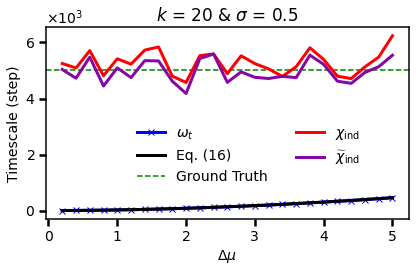

In [54]:
lag =20
sigma0=muydata['sigma1=sigma2'][0]
plt.rc('font',size=14,weight='normal')

plt.plot(muydata['muy2'],t_xVAMP,marker='x',label=r'$\omega_t$',lw=3,color='blue')
plt.plot(muydata['muy2'],tmuy_theo,label='Eq. (16)',lw=3,color='black')
plt.axhline(y=5000,ls='--',color='green',label='Ground Truth')
plt.plot(muydata['muy2'],t_iKSVAMP,label='$\chi_{\mathrm{ind}}$',lw=3,color='red')
plt.plot(muydata['muy2'],t_iVAMP,label='$\widetilde{\chi}_{\mathrm{ind}}$',lw=3,color=colors[3])
#plt.plot(muydata['muy2'],t_iMSM,label='MSM $\chi_{\mathrm{ind}}$($x_t$)',lw=3,color='orange')
plt.ylabel('Timescale (step)',weight='normal' )
plt.xlabel(r'$\Delta \mu$',weight='normal')

plt.title(r'$k$ = '+str(lag)+' & $\sigma$ = '+str(sigma0),weight='normal')
plt.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
plt.legend(frameon=False,bbox_to_anchor=(0.4, 0.05, 0.5, 0.5),ncol=2)
plt.tight_layout()
plt.savefig(str(sigma0)+str(lag)+'vs.muy2.png',dpi=300,bbox_inches='tight')

In [55]:
lag=200
sigma0=muydata['sigma1=sigma2'][0]
tmuy_theo200, t_xVAMP200, t_iVAMP200, t_iKSVAMP200, t_iMSM200=compare_VAMP_vs_theoretical(lag=lag,maxi=1000000)

using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(1000000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indic

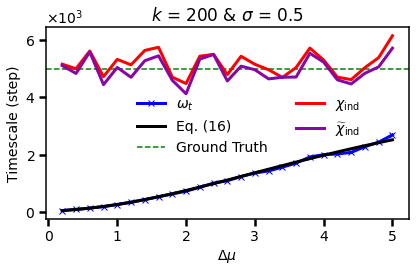

In [56]:
#lag =200
sigma0=muydata['sigma1=sigma2'][0]
plt.rc('font',size=14,weight='normal')

colors = cm.plasma(np.linspace(0,1,12))
plt.plot(muydata['muy2'],t_xVAMP200,marker='x',label=r'$\omega_t$',lw=3,color='blue')
plt.plot(muydata['muy2'],tmuy_theo200,label='Eq. (16)',lw=3,color='black')
plt.axhline(y=5000,ls='--',color='green',label='Ground Truth')
plt.plot(muydata['muy2'],t_iKSVAMP200,label='$\chi_{\mathrm{ind}}$',lw=3,color='red')
plt.plot(muydata['muy2'],t_iVAMP200,label='$\widetilde{\chi}_{\mathrm{ind}}$',lw=3,color=colors[3])
#plt.plot(muydata['muy2'],t_iMSM200,label='MSM $\chi_{\mathrm{ind}}$($x_t$)',lw=3,color='orange')
plt.ylabel('Timescale (step)',weight='normal' )
plt.xlabel(r'$\Delta \mu$',weight='normal')

plt.title(r'$k$ = '+str(lag)+' & $\sigma$ = '+str(sigma0),weight='normal')
plt.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
plt.legend(frameon=False,bbox_to_anchor=(0.4, 0.2, 0.5, 0.5),ncol=2)
plt.tight_layout()
plt.savefig(str(sigma0)+str(lag)+'vs.muy2.png',dpi=300,bbox_inches='tight')

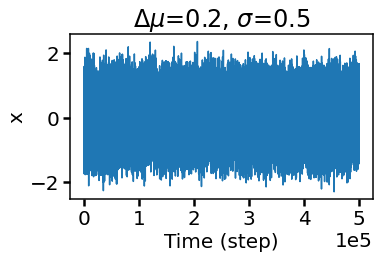

In [61]:
sigma0=muydata['sigma1=sigma2'][0]
i=0
n=500000
plt.rc('font',size=20,weight='normal')
muy2=muydata['muy2'][i]
x=muydata['timeseries'][i][:n]
x=x-np.average(x)
t=np.arange(len(x))
plt.plot(t,x)
plt.title(r'$\Delta \mu$='+str(muy2)[:3]+', $\sigma $='+ str(sigma0),weight='normal')
plt.ylabel(r'x',weight='normal')
plt.xlabel('Time (step)',weight='normal')
c
plt.tight_layout()
plt.ticklabel_format(scilimits=(-3,4),style='sci')
plt.savefig('Timesereies_at'+str(sigma0)+str(muy2)[:3]+'.png',dpi=300,bbox_inches='tight')

500000


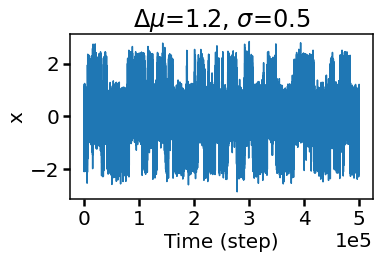

In [62]:
sigma0=muydata['sigma1=sigma2'][0]
i=5
n=500000
plt.rc('font',size=20,weight='normal')
muy2=muydata['muy2'][i]
x=muydata['timeseries'][i][:n]
x=x-np.average(x)
t=np.arange(len(x))
print(len(x))
plt.plot(t,x)
plt.title(r'$\Delta \mu$='+str(muy2)[:3]+', $\sigma $='+ str(sigma0),weight='normal')
plt.ylabel(r'x',weight='normal')
plt.xlabel('Time (step)',weight='normal')
plt.xticks([0,100000,200000,300000,400000,500000])
plt.tight_layout()
plt.ticklabel_format(scilimits=(-3,4),style='sci')
plt.savefig('Timesereies_at'+str(sigma0)+str(muy2)[:3]+'.png',dpi=300,bbox_inches='tight')

In [27]:
# testing polynomial functions
vampscore=[]
timescale=[]
fri=9
x=df['timeseries'][fri]
upto_data=[]
lag=2000
for i in range(1,30):
    upto_data.append(x**i)
    tg=coor.vamp(upto_data,dim=1,lag=lag)
    score=tg.score()
    vampscore.append(score)
    timescale.append(-lag/np.log(tg.singular_values[0]))
    print(np.shape(upto_data),i,score,timescale[-1])

(1, 500000) 1 1.0827826371047562 1605.4347585980902
(2, 500000) 2 1.045593219013878 1295.3383482815245


calculate covariances:   0%|                                          | 0/3 [00:00<?, ?it/s]

(3, 500000) 3 1.0251431062876954 1086.0205597451147


calculate covariances:   0%|                                          | 0/4 [00:00<?, ?it/s]

(4, 500000) 4 1.0129652217977159 920.4956932593869


calculate covariances:   0%|                                          | 0/5 [00:00<?, ?it/s]

(5, 500000) 5 1.006697385184945 799.0350693232044


calculate covariances:   0%|                                          | 0/6 [00:00<?, ?it/s]

(6, 500000) 6 1.0033182625652004 700.7323055971503


calculate covariances:   0%|                                          | 0/7 [00:00<?, ?it/s]

(7, 500000) 7 1.0015213132887806 616.5055826939985


calculate covariances:   0%|                                          | 0/8 [00:00<?, ?it/s]

(8, 500000) 8 1.0006540699850146 545.531698402756


calculate covariances:   0%|                                          | 0/9 [00:00<?, ?it/s]

(9, 500000) 9 1.0002613032778394 484.85854397866166


calculate covariances:   0%|                                         | 0/10 [00:00<?, ?it/s]

(10, 500000) 10 1.0000987700615704 433.7117169679998


calculate covariances:   0%|                                         | 0/11 [00:00<?, ?it/s]

(11, 500000) 11 1.00003529970419 390.1816266363235


calculate covariances:   0%|                                         | 0/12 [00:00<?, ?it/s]

(12, 500000) 12 1.0000120764668694 353.2242165126767


calculate covariances:   0%|                                         | 0/13 [00:00<?, ?it/s]

(13, 500000) 13 1.0000039764078883 321.6692915476914


calculate covariances:   0%|                                         | 0/14 [00:00<?, ?it/s]

(14, 500000) 14 1.0000012732472054 294.6823089345398


calculate covariances:   0%|                                         | 0/15 [00:00<?, ?it/s]

(15, 500000) 15 1.0000003992929387 271.4888423028255


calculate covariances:   0%|                                         | 0/16 [00:00<?, ?it/s]

(16, 500000) 16 1.000000123421796 251.4512174849525


calculate covariances:   0%|                                         | 0/17 [00:00<?, ?it/s]

(17, 500000) 17 1.0000000377405343 234.02034298171287


calculate covariances:   0%|                                         | 0/18 [00:00<?, ?it/s]

(18, 500000) 18 1.000000011426301 218.7304574409452


calculate covariances:   0%|                                         | 0/19 [00:00<?, ?it/s]

(19, 500000) 19 1.0000000034191066 205.19253507592367


calculate covariances:   0%|                                         | 0/20 [00:00<?, ?it/s]

(20, 500000) 20 1.0000000010052856 193.06888392320656


calculate covariances:   0%|                                         | 0/21 [00:00<?, ?it/s]

(21, 500000) 21 1.0000000002873568 182.0639983790363


calculate covariances:   0%|                                         | 0/22 [00:00<?, ?it/s]

(22, 500000) 22 1.0000000000782676 171.88858995835702


calculate covariances:   0%|                                         | 0/23 [00:00<?, ?it/s]

(23, 500000) 23 1.0000000000195541 162.22025157750068


calculate covariances:   0%|                                         | 0/24 [00:00<?, ?it/s]

(24, 500000) 24 1.0000000000041176 152.5800488085644


calculate covariances:   0%|                                         | 0/25 [00:00<?, ?it/s]

(25, 500000) 25 1.0000000000005715 141.89278922907835


calculate covariances:   0%|                                         | 0/26 [00:00<?, ?it/s]

(26, 500000) 26 1.0000000000000093 123.81929760257304


calculate covariances:   0%|                                         | 0/27 [00:00<?, ?it/s]

(27, 500000) 27 1.0000000000000524 130.8102201037023


calculate covariances:   0%|                                         | 0/28 [00:00<?, ?it/s]

(28, 500000) 28 1.000000000000141 135.1838768160011


calculate covariances:   0%|                                         | 0/29 [00:00<?, ?it/s]

(29, 500000) 29 1.0000000000001834 136.39017329301763


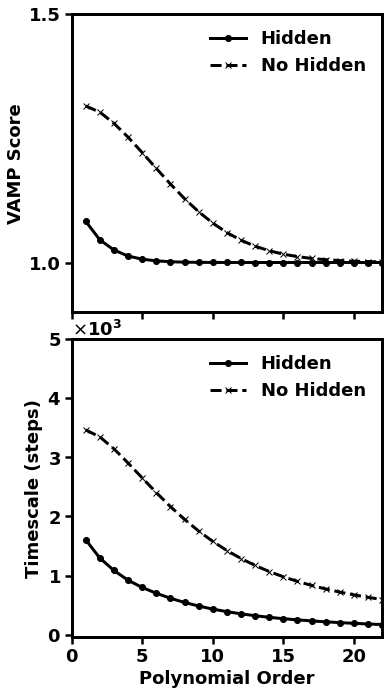

In [45]:
vampscore_nooverlap=[1.314615466257613, 1.3021232725141187, 1.2797318811168452, 1.2518699603291101, 1.220996164171608, 1.1890551956817146, 1.1577204321208567, 1.1283576800232713, 1.1019676538526602, 1.079151640016035, 1.060124651144606, 1.0447757079091518, 1.0327599898836217, 1.0236001023069614, 1.0167757382979759, 1.0117892560030368, 1.0082042518600054, 1.0056612053243683, 1.0038773581299474, 1.0026379033612716, 1.0017838264778645, 1.0011996754851644, 1.0008028599300482, 1.0005349918539892, 1.0003552055497746, 1.0002351569184202, 1.0001553534596117, 1.0001024985766798, 1.0000675918114803]
timescale_nooverlap=[3458.9983756241572, 3341.910464174527, 3139.905469753318, 2900.9842823613303, 2649.69109509913, 2401.3693579470323, 2165.7547041490748, 1948.4303703427922, 1752.004134438823, 1577.0446811228146, 1422.811403875739, 1287.792889812607, 1170.0876469667073, 1067.661946280762, 978.5162871082603, 900.785934952914, 832.7950112402875, 773.078551466344, 720.3830815051501, 673.653479596014, 632.0119239025694, 594.7332633602133, 561.2199569567482, 530.9786879962612, 503.5998625899172, 478.74048002237066, 456.11034568375686, 435.46128241561877, 416.57885036085503]
rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=18,weight='bold')
#majorLocator = MultipleLocator(50)
#majorFormatter = FormatStrFormatter('%d')
#minorLocator = MultipleLocator(25)

lag=range(1,50,2)
fig,(ax,ax2)=plt.subplots(2,1,figsize=(6,10),sharex=True)
ax.plot(np.arange(1,30),vampscore,lw=3,color='black',marker='o',label=r'Hidden')
ax.plot(np.arange(1,30),vampscore_nooverlap,lw=3,color='black',marker='x',ls='--',label=r'No Hidden')
ax.set_ylabel('VAMP Score',weight='bold')
#ax.set_xlabel(r'$n$',weight='bold')
ax.set_ylim(0.9,1.5)
ax.set_yticks([1,1.5])
ax.set_xlim(0,22)

ax2.plot(np.arange(1,30),timescale,lw=3,color='black',marker='o',label=r'Hidden')
ax2.plot(np.arange(1,30),timescale_nooverlap,lw=3,color='black',marker='x',ls='--',label=r'No Hidden')
ax2.set_ylabel('Timescale (steps)',weight='bold')
ax2.set_xlabel(r'Polynomial Order',weight='bold')
#ax2.set_ylim(0.9,2)
#ax2.set_yticks([1,1.5,2])
ax2.set_xlim(0,22)

plt.tight_layout()
ax.legend(frameon=False)
ax2.legend(frameon=False)
plt.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
plt.yticks([0,1000,2000,3000,4000,5000])
plt.savefig('poly.png',dpi=300,bbox_inches='tight')